In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error

data = pd.read_csv('Amazon.csv')

data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
...,...,...,...,...,...,...,...
5837,2020-07-27,3062.000000,3098.000000,3015.770020,3055.209961,3055.209961,4170500
5838,2020-07-28,3054.270020,3077.090088,2995.760010,3000.330078,3000.330078,3126700
5839,2020-07-29,3030.989990,3039.159912,2996.770020,3033.530029,3033.530029,2974100
5840,2020-07-30,3014.000000,3092.000000,3005.000000,3051.879883,3051.879883,6128300


In [2]:
data = data[['Date', 'Close']]
data

,Date,Close
0,1997-05-15,1.958333
1,1997-05-16,1.729167
2,1997-05-19,1.708333
3,1997-05-20,1.635417
4,1997-05-21,1.427083
...,...,...
5837,2020-07-27,3055.209961
5838,2020-07-28,3000.330078
5839,2020-07-29,3033.530029
5840,2020-07-30,3051.879883


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

<ipython-input-4-27440ea654b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


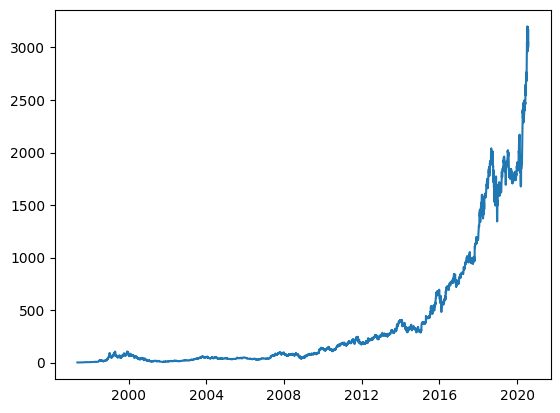

In [4]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [5]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,1.583333,1.500000,1.395833,1.427083,1.635417,1.708333,1.729167,1.958333
1997-05-28,1.531250,1.583333,1.500000,1.395833,1.427083,1.635417,1.708333,1.729167
1997-05-29,1.505208,1.531250,1.583333,1.500000,1.395833,1.427083,1.635417,1.708333
1997-05-30,1.500000,1.505208,1.531250,1.583333,1.500000,1.395833,1.427083,1.635417
1997-06-02,1.510417,1.500000,1.505208,1.531250,1.583333,1.500000,1.395833,1.427083
...,...,...,...,...,...,...,...,...
2020-07-27,3055.209961,3008.909912,2986.550049,3099.909912,3138.290039,3196.840088,2961.969971,2999.899902
2020-07-28,3000.330078,3055.209961,3008.909912,2986.550049,3099.909912,3138.290039,3196.840088,2961.969971
2020-07-29,3033.530029,3000.330078,3055.209961,3008.909912,2986.550049,3099.909912,3138.290039,3196.840088


In [6]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[1.58333337e+00, 1.50000000e+00, 1.39583337e+00, ...,
        1.70833337e+00, 1.72916663e+00, 1.95833337e+00],
       [1.53125000e+00, 1.58333337e+00, 1.50000000e+00, ...,
        1.63541663e+00, 1.70833337e+00, 1.72916663e+00],
       [1.50520837e+00, 1.53125000e+00, 1.58333337e+00, ...,
        1.42708337e+00, 1.63541663e+00, 1.70833337e+00],
       ...,
       [3.03353003e+03, 3.00033008e+03, 3.05520996e+03, ...,
        3.09990991e+03, 3.13829004e+03, 3.19684009e+03],
       [3.05187988e+03, 3.03353003e+03, 3.00033008e+03, ...,
        2.98655005e+03, 3.09990991e+03, 3.13829004e+03],
       [3.16467993e+03, 3.05187988e+03, 3.03353003e+03, ...,
        3.00890991e+03, 2.98655005e+03, 3.09990991e+03]])

In [7]:
shifted_df_as_np.shape

(5835, 8)

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.99989579, -0.99994789, -1.        , ..., -0.9998046 ,
        -0.99979158, -0.99964828],
       [-0.99992835, -0.99989579, -0.99993487, ..., -0.9998502 ,
        -0.9998046 , -0.99979158],
       [-0.99994464, -0.99992835, -0.99988276, ..., -0.99998046,
        -0.9998502 , -0.9998046 ],
       ...,
       [ 0.89591019,  0.87515103,  0.90946674, ...,  0.9374164 ,
         0.96141444,  0.99802419],
       [ 0.90738392,  0.89591019,  0.87515184, ...,  0.86653556,
         0.9374164 ,  0.96141444],
       [ 0.97791518,  0.90738392,  0.89591086, ...,  0.88051658,
         0.86653556,  0.9374164 ]])

In [9]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((5835, 7), (5835,))

In [10]:
X = dc(np.flip(X, axis=1))
X

array([[-0.99964828, -0.99979158, -0.9998046 , ..., -0.99998046,
        -1.        , -0.99994789],
       [-0.99979158, -0.9998046 , -0.9998502 , ..., -1.        ,
        -0.99993487, -0.99989579],
       [-0.9998046 , -0.9998502 , -0.99998046, ..., -0.99993487,
        -0.99988276, -0.99992835],
       ...,
       [ 0.99802419,  0.96141444,  0.9374164 , ...,  0.88051658,
         0.90946674,  0.87515103],
       [ 0.96141444,  0.9374164 ,  0.86653556, ...,  0.90946674,
         0.87515184,  0.89591019],
       [ 0.9374164 ,  0.86653556,  0.88051658, ...,  0.87515184,
         0.89591086,  0.90738392]])

In [11]:
split_index = int(len(X) * 0.95)

split_index

5543

In [12]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5543, 7), (292, 7), (5543,), (292,))

In [13]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5543, 7, 1), (292, 7, 1), (5543, 1), (292, 1))

In [14]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5543, 7, 1]),
 torch.Size([292, 7, 1]),
 torch.Size([5543, 1]),
 torch.Size([292, 1]))

In [15]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [16]:
train_dataset

In [17]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [19]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [20]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [21]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [22]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 1.220
Batch 200, Loss: 0.386
Batch 300, Loss: 0.064

Val Loss: 0.147
***************************************************

Epoch: 2
Batch 100, Loss: 0.013
Batch 200, Loss: 0.004
Batch 300, Loss: 0.002

Val Loss: 0.028
***************************************************

Epoch: 3
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.000

Val Loss: 0.031
***************************************************

Epoch: 4
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.034
***************************************************

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.033
***************************************************

Epoch: 6
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.031
***************************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.030
*****************

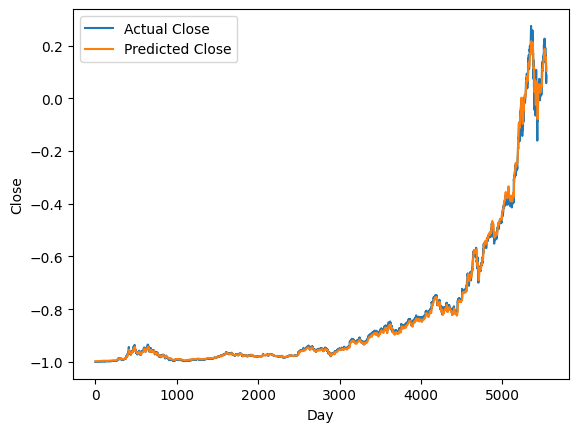

In [23]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [24]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([   6.00924468,    5.98388817,    5.96577638, ..., 1803.97175973,
       1778.43554157, 1766.35969609])

In [25]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([1.58329510e+00, 1.53124753e+00, 1.50522375e+00, ...,
       1.69268994e+03, 1.72956005e+03, 1.73850000e+03])

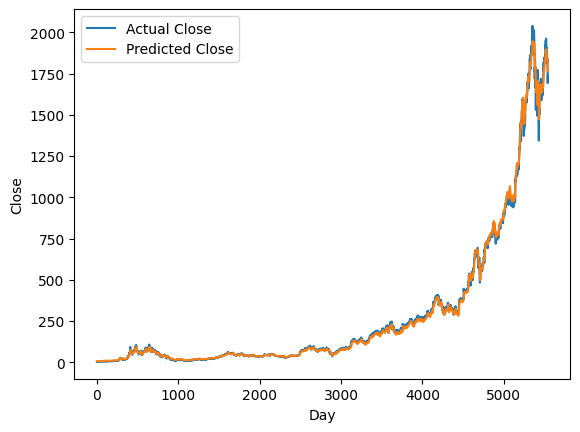

In [26]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [27]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([1757.14124766, 1752.31876903, 1759.2804169 , 1776.73126977,
       1794.02824391, 1810.40030136, 1824.87655482, 1835.63557783,
       1846.38096933, 1855.65532599, 1862.34598812, 1869.50636522,
       1874.2769631 , 1878.03494509, 1874.18997885, 1874.11519622,
       1874.39852658, 1872.34519769, 1875.87835517, 1881.25014533,
       1886.57007857, 1892.9751702 , 1899.14113853, 1910.50788359,
       1925.21742168, 1932.97157953, 1940.72228184, 1948.40997419,
       1952.22071868, 1951.55801781, 1947.10442392, 1940.01730424,
       1938.68746987, 1938.78763284, 1939.83234949, 1936.25705827,
       1928.50244763, 1917.00598878, 1905.375884  , 1889.03604647,
       1873.30128573, 1854.1638439 , 1828.50448939, 1813.20159952,
       1802.67729102, 1802.55355889, 1799.05683948, 1792.90659981,
       1797.11001268, 1790.60151703, 1787.04021479, 1786.65958122,
       1789.36555417, 1789.93495549, 1795.92128346, 1795.59994217,
       1787.22357283, 1783.39793377, 1777.62289414, 1772.39688

In [28]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([1754.35997971, 1804.03002727, 1860.63001515, 1863.69993976,
       1855.31994806, 1870.30004294, 1869.67003861, 1886.03003742,
       1901.36998496, 1908.79002795, 1918.18995175, 1911.30005993,
       1913.90003124, 1878.27001707, 1897.82996407, 1904.28002536,
       1893.63000674, 1922.18994062, 1934.31006466, 1938.99999358,
       1942.91004311, 1952.31995222, 1988.30004824, 2017.41005625,
       2001.06993276, 2011.00000772, 2020.98999458, 2009.90000244,
       1992.03002845, 1977.90001999, 1964.52003029, 1985.63001289,
       1994.48999086, 2000.81007623, 1973.81995794, 1943.05005201,
       1912.44994412, 1898.53003242, 1866.78004034, 1855.31994806,
       1823.23998776, 1765.13000086, 1787.82996033, 1793.40002694,
       1832.89002108, 1807.57996198, 1784.92003909, 1824.33996921,
       1762.95995816, 1776.11999685, 1792.56994691, 1816.12000471,
       1801.38001021, 1823.54004769, 1804.66003159, 1749.61999313,
       1768.86999021, 1761.82996119, 1764.24999425, 1786.40002

In [33]:
# Test tahminlerini ve gerçek değerleri kullanarak RMSE'yi hesapla
rmse = np.sqrt(mean_squared_error(new_y_test, test_predictions))

print(f"Root Mean Square Error (RMSE): {rmse:.2f}")

Root Mean Square Error (RMSE): 205.39


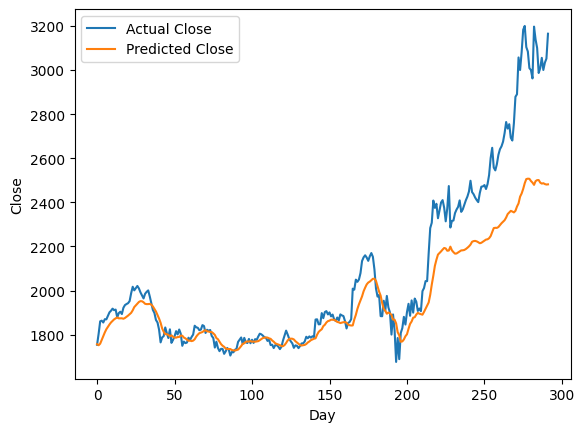

In [29]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [31]:
# Save the model
torch.save(model.state_dict(), 'amazon_stock_lstm_model.pth')
print("Model saved successfully.")

Model saved successfully.
